# GeoBench MMFlood

In [1]:
import matplotlib.pyplot as plt
import json
from pathlib import Path
import numpy as np
import pandas as pd
import os

from geobench_v2.datamodules import GeoBenchMMFloodDataModule
from geobench_v2.datasets import GeoBenchMMFlood
from geobench_v2.datasets.data_util import ClipZScoreNormalizer, SatMAENormalizer
from geobench_v2.datasets.visualization_util import (
    compute_batch_histograms,
    plot_batch_histograms,
    plot_channel_histograms,
)
import tacoreader
from geobench_v2.datasets.visualization_util import (
    compute_batch_histograms,
    plot_batch_histograms,
)
import torch
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
PROJECT_ROOT = Path("../../")

In [3]:
band_order = GeoBenchMMFlood.band_default_order

datamodule = GeoBenchMMFloodDataModule(
    img_size=120,
    batch_size=16,
    num_workers=4,
    root=PROJECT_ROOT / "data" / "mmflood",
    band_order=band_order,
    data_normalizer=torch.nn.Identity(),  # we do custom normalization in the tutorial
)
datamodule.setup("fit")

Using provided pre-initialized normalizer instance: Identity
Using provided pre-initialized normalizer instance: Identity


Map extent: Longitude [-101.53° to 157.99°], Latitude [-38.81° to 75.55°]
Found 3 dataset splits: test, train, validation


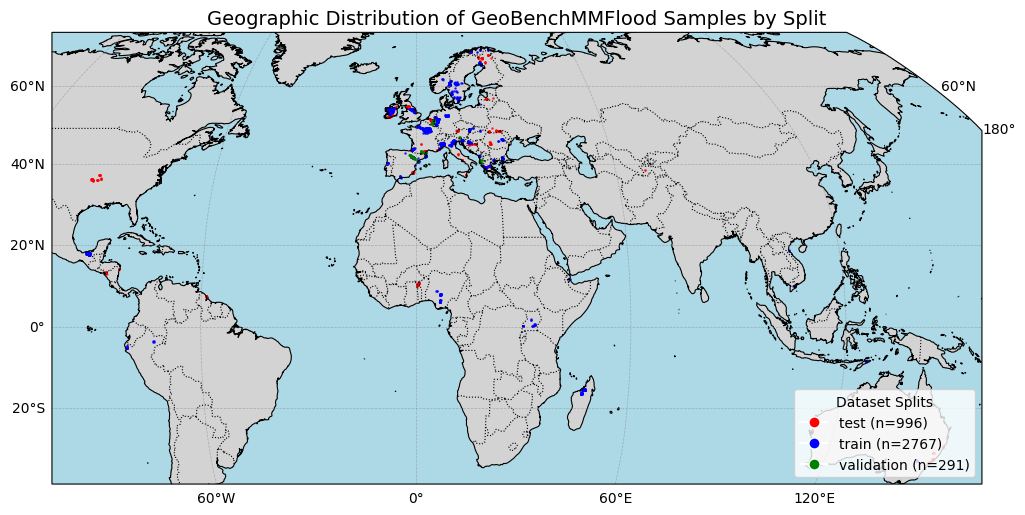

In [4]:
sample_dist_fig = datamodule.visualize_geospatial_distribution()

In [5]:
STATS_DIR = os.path.join(
    PROJECT_ROOT, "geobench_v2", "generate_benchmark", "dataset_stats"
)
STATS_WITH_CLIP_DIR = os.path.join(
    PROJECT_ROOT, "geobench_v2", "generate_benchmark", "dataset_stats_with_clip"
)

# Load dataset statistics from JSON files
direct_stats_path = os.path.join(STATS_DIR, "mmflood", "mmflood_stats.json")
satmae_stats_path = os.path.join(STATS_WITH_CLIP_DIR, "mmflood", "mmflood_stats.json")


def create_normalizer_from_stats(stats_path, normalizer_class, band_order):
    """Create a data normalizer from a stats JSON file."""
    with open(stats_path, "r") as f:
        stats = json.load(f)

    means = {}
    stds = {}
    clip_min = {}
    clip_max = {}

    for modality, modality_stats in stats["input_stats"].items():
        bands = modality_stats["band_names"]
        mean_values = modality_stats["mean"]
        std_values = modality_stats["std"]

        if "clip_min_used" in modality_stats:
            clip_min[modality] = modality_stats["clip_min_used"]
        if "clip_max_used" in modality_stats:
            clip_max[modality] = modality_stats["clip_max_used"]

        for i, band in enumerate(bands):
            if i < len(mean_values) and i < len(std_values):
                means[band] = mean_values[i]
                stds[band] = std_values[i]

    norm_stats = {
        "means": means,
        "stds": stds,
        "clip_min": clip_min,
        "clip_max": clip_max,
    }
    print(norm_stats)

    # Create normalizer instance
    if normalizer_class == SatMAENormalizer:
        return normalizer_class(norm_stats, band_order, output_range="zero_one")
    else:
        return normalizer_class(norm_stats, band_order)


multimodal_normalizer = create_normalizer_from_stats(
    direct_stats_path, ClipZScoreNormalizer, band_order
)
satmae_normalizer = create_normalizer_from_stats(
    satmae_stats_path, SatMAENormalizer, band_order
)

{'means': {'vv': 0.19102874398231506, 'vh': 0.03612856939435005, 'dem': 131.25657653808594, 'hydro': 0.018626466393470764}, 'stds': {'vv': 2.25282621383667, 'vh': 0.16889090836048126, 'dem': 213.15255737304688, 'hydro': 0.13520178198814392}, 'clip_min': {}, 'clip_max': {}}
{'means': {'vv': 10.0, 'vh': 10.0, 'dem': 121.45863342285156, 'hydro': 0.020118817687034607}, 'stds': {'vv': 9.999999747378752e-05, 'vh': 9.999999747378752e-05, 'dem': 190.54788208007812, 'hydro': 0.1404067873954773}, 'clip_min': {'image_s1': 10, 'image_dem': -1, 'image_hydro': 0}, 'clip_max': {'image_s1': 10, 'image_dem': 2000, 'image_hydro': 1}}


### Raw Image Statistics

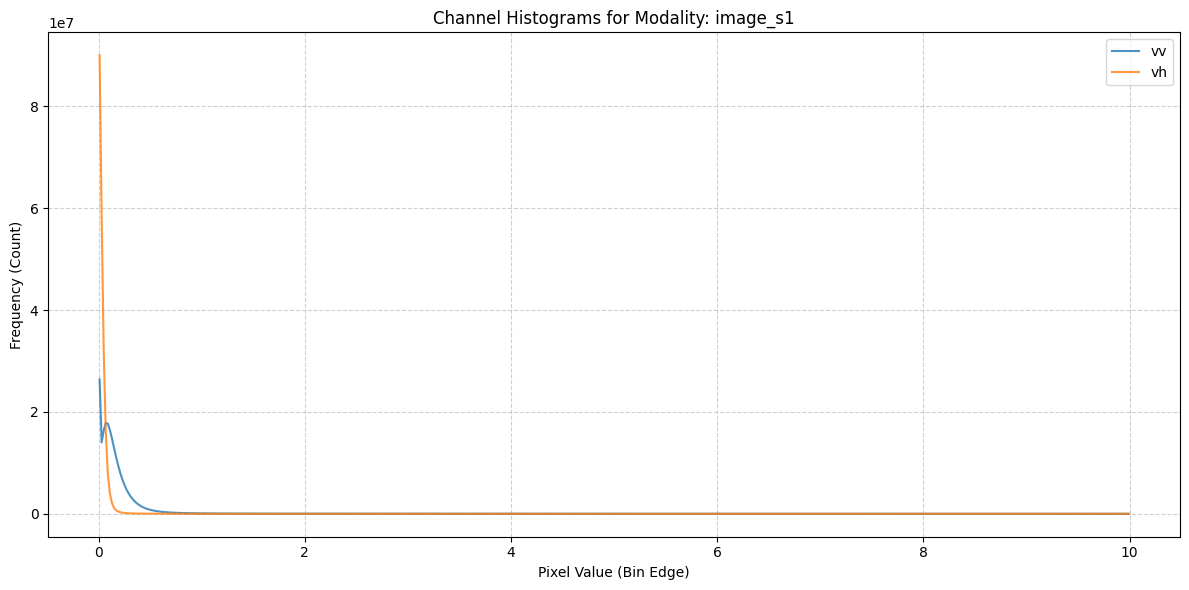

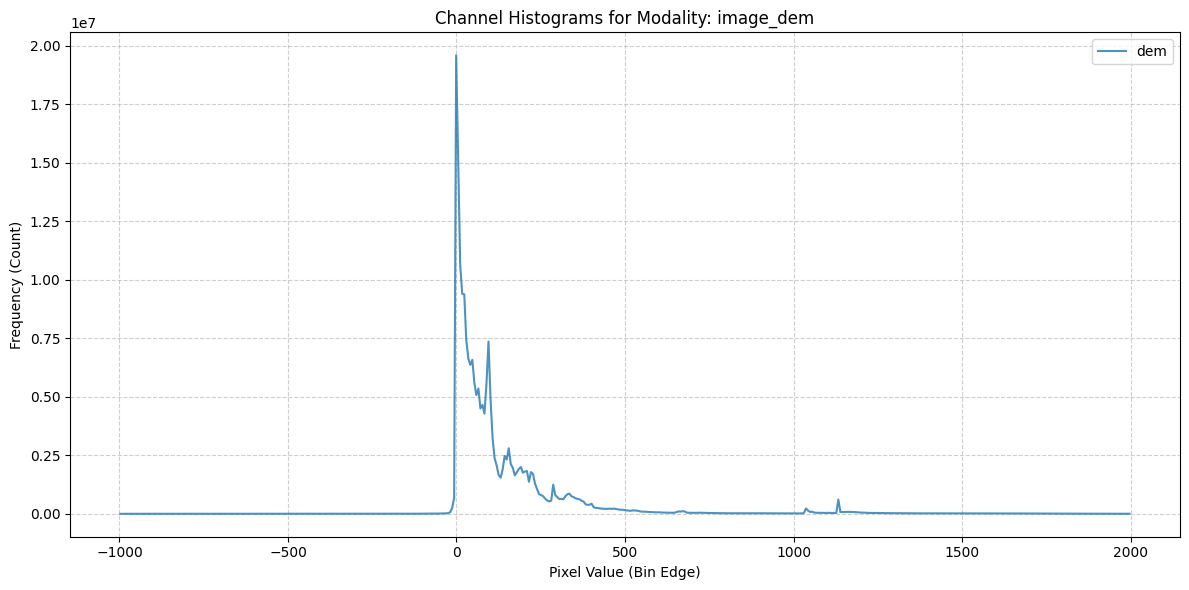

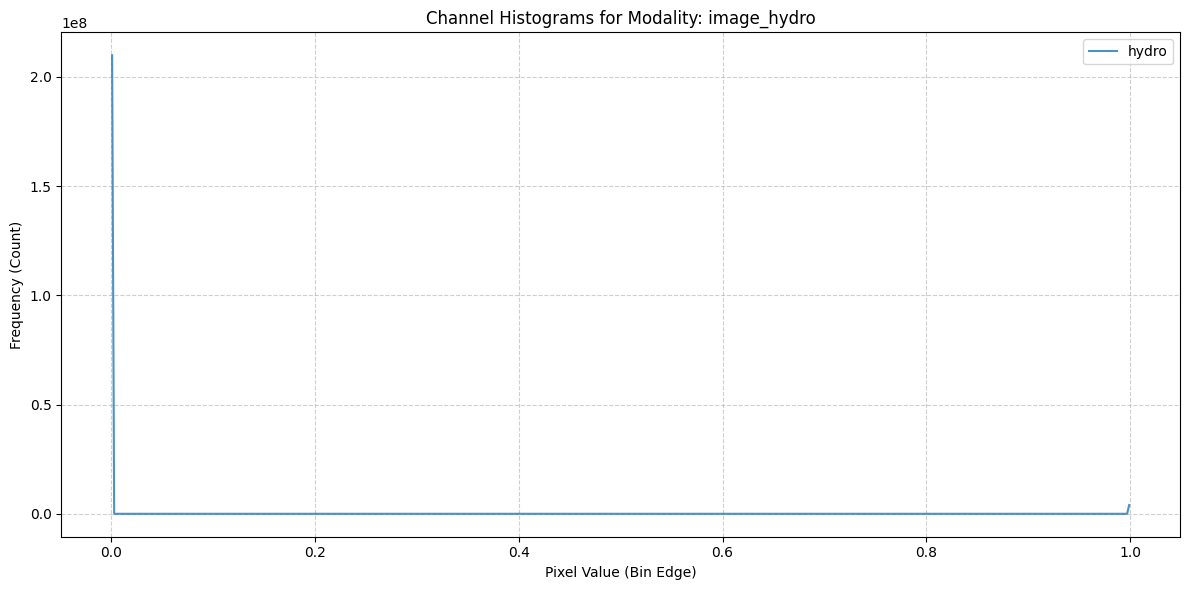

In [6]:
fig = plot_channel_histograms(
    "/home/nils/projects/GEO-Bench-2/geobench_v2/generate_benchmark/dataset_stats/mmflood/mmflood_stats.json"
)

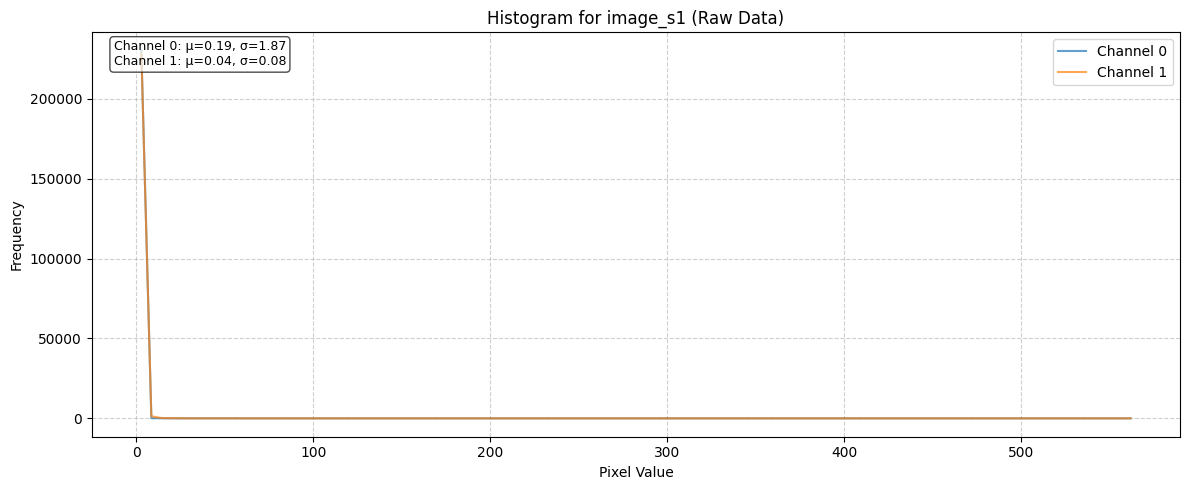

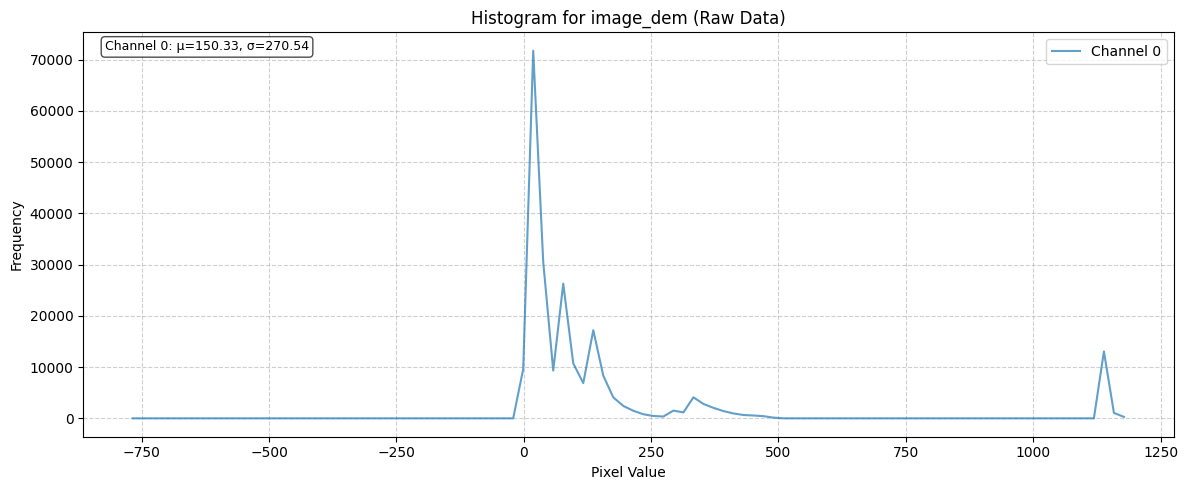

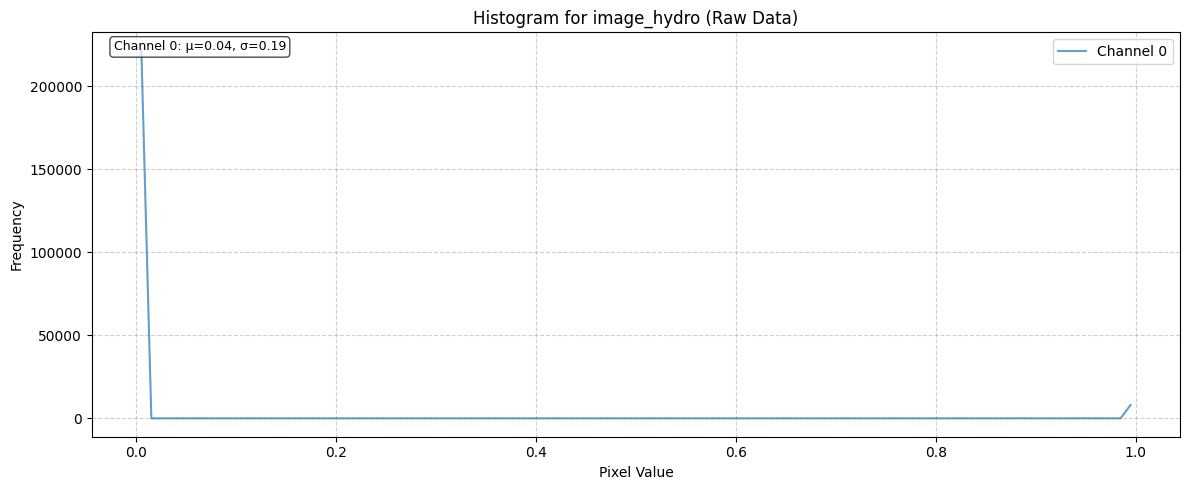

In [7]:
# Get a batch of data from the dataloader
train_dataloader = datamodule.train_dataloader()
raw_batch = next(iter(train_dataloader))

raw_batch_stats = compute_batch_histograms(raw_batch, n_bins=100)

raw_figs = plot_batch_histograms(
    raw_batch_stats, band_order, title_suffix=" (Raw Data)"
)

In [8]:
satmae_normalizer.means.keys()

dict_keys(['image_s1', 'image_dem', 'image_hydro'])

[<Figure size 1200x500 with 1 Axes>,
 <Figure size 1200x500 with 1 Axes>,
 <Figure size 1200x500 with 1 Axes>]

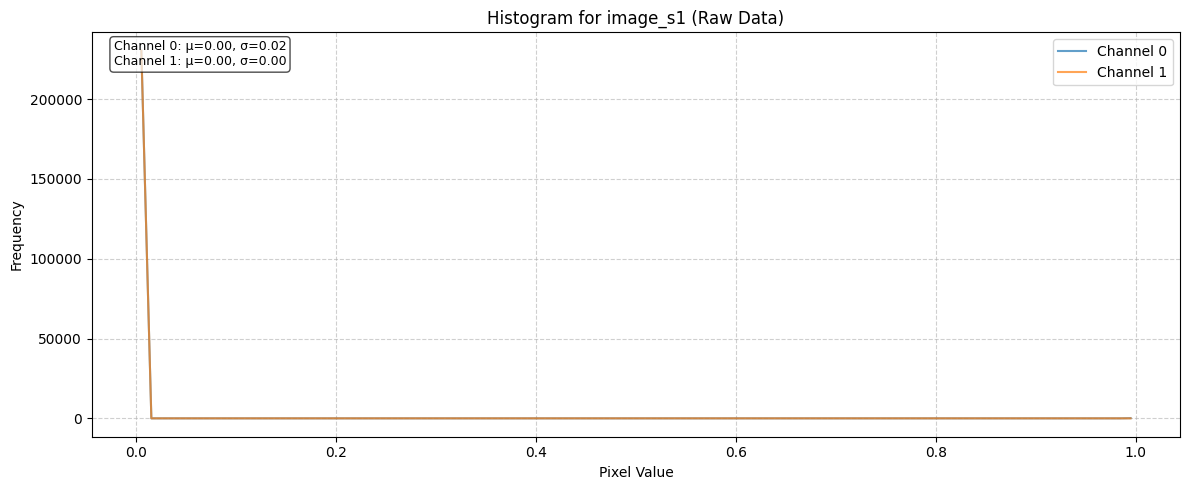

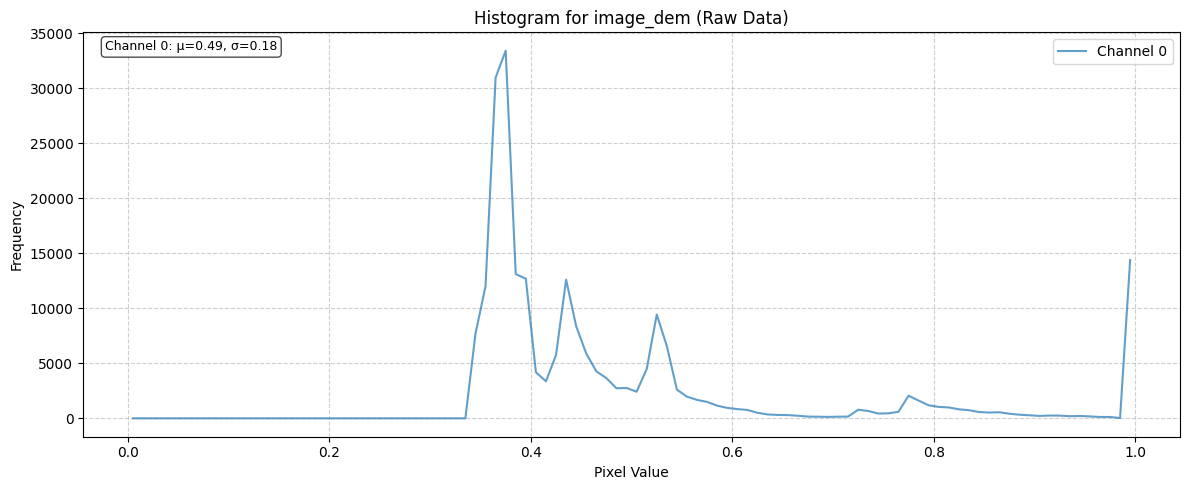

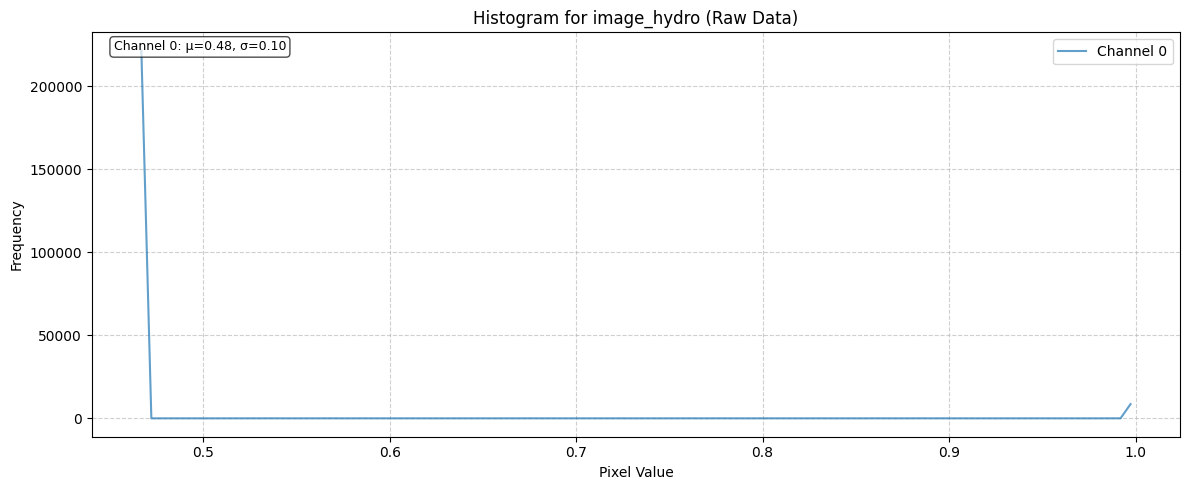

In [9]:
satmae_normalized_batch = satmae_normalizer(raw_batch)
satmae_batch_stats = compute_batch_histograms(satmae_normalized_batch, n_bins=100)
sat_mae_norm_fig = plot_batch_histograms(
    satmae_batch_stats, band_order, title_suffix=" (Raw Data)"
)
sat_mae_norm_fig

[<Figure size 1200x500 with 1 Axes>,
 <Figure size 1200x500 with 1 Axes>,
 <Figure size 1200x500 with 1 Axes>]

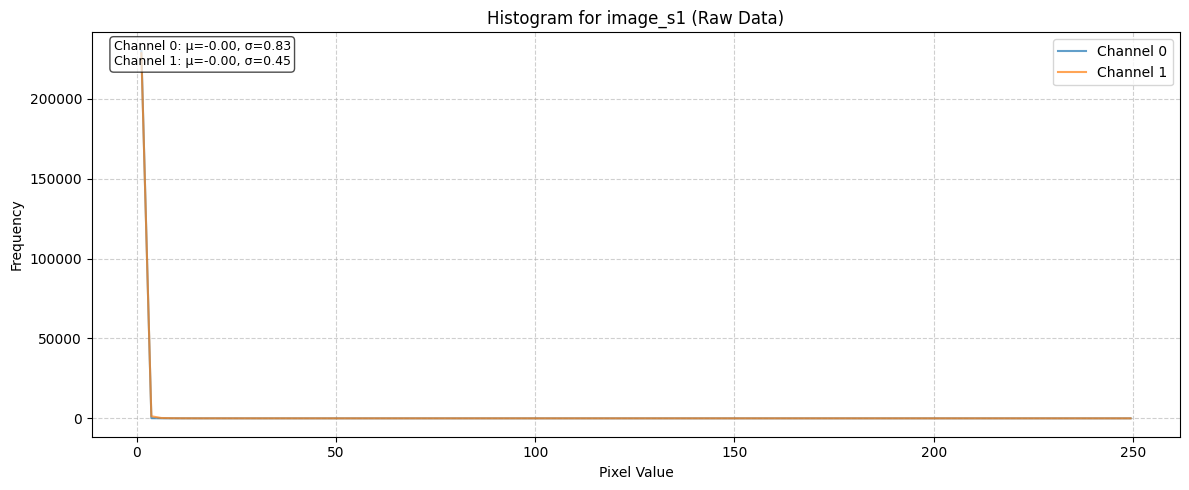

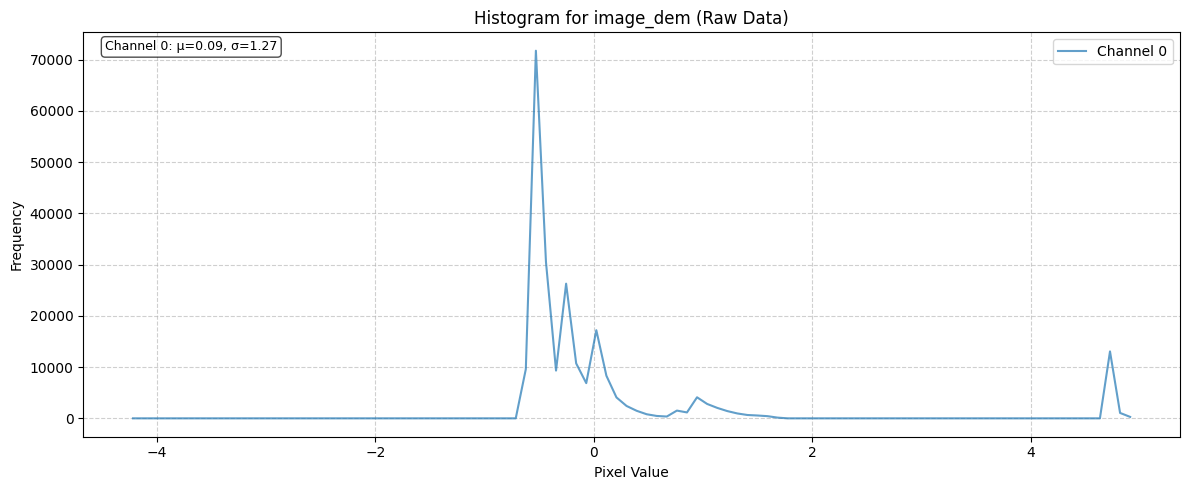

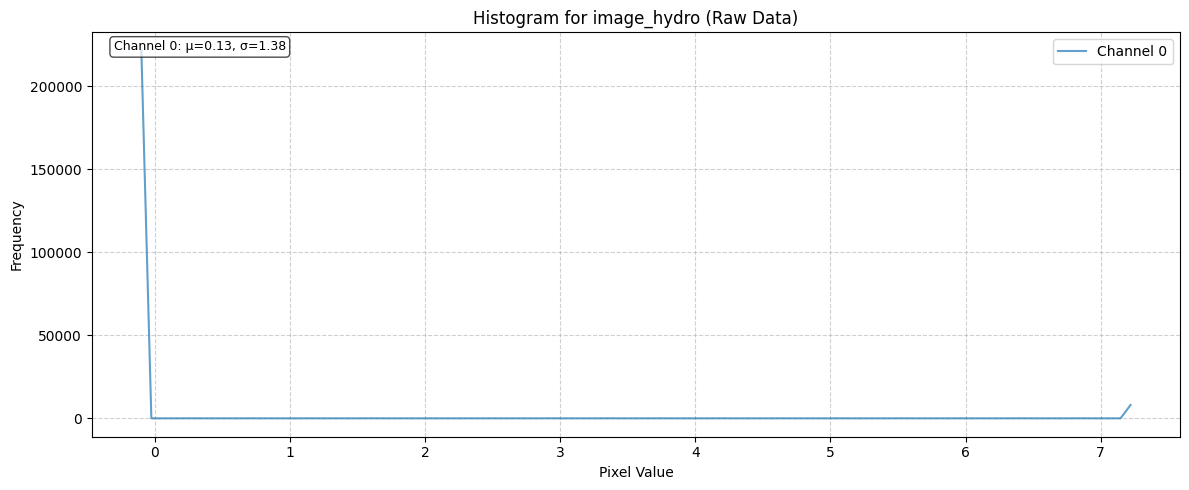

In [10]:
mn_normalized_batch = multimodal_normalizer(raw_batch)
mn_batch_stats = compute_batch_histograms(mn_normalized_batch, n_bins=100)
mn_norm_fig = plot_batch_histograms(
    mn_batch_stats, band_order, title_suffix=" (Raw Data)"
)
mn_norm_fig